In [396]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, trustworthiness
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [397]:
# CONSTANTS

EXCEL_PATH = "NEW_Miyokardit_08.12.2025.xlsx"
LABEL_COL  = "GRUP"
EPS        = 1e-12          # to avoid taking log2(0)
N_BINS = 20                 # for discretisizing features

In [398]:
# HELPERS
def kl_divergence(p, q, eps=EPS):
    """
    D_KL(p || q)
    """
    union_idx = p.index.union(q.index) # combine all unique values from both p and q
    p, q = p.reindex(union_idx, fill_value=0), q.reindex(union_idx, fill_value=0) # ensures both series have the same indices. Missing ones are replaced by 0
    return float(np.sum(p * np.log2((p + eps) / (q + eps))))

def get_distribution(series):
    # get the PMF of a feature
    return series.value_counts(normalize=True)

def discretise(series):
    # PMF might be near continuous so get_distribution would create 1/N tiny spikes in the dist.
    ## seperate into 20 bins
    if series.nunique() > N_BINS*2: # if more than N_BINS*2 unique values
            return pd.qcut(series, q=N_BINS, duplicates="drop") # EXPLAIN WHY YOU USE THIS AND NOT pd.cut
    return series

def shannon_entropy(p, eps=EPS):
    """H(p)  (base-2).  `p` is a pandas Series whose values sum to 1."""
    return float(-np.sum(p * np.log2(p + eps)))

def js_divergence(p, q, eps=EPS):
    """
    Jensen-Shannon divergence.
    Symmetric, bounded in [0, 1] when log base is 2.
    """
    union = p.index.union(q.index)
    p, q = p.reindex(union, fill_value=0), q.reindex(union, fill_value=0)
    m = 0.5 * (p + q)
    kl_p_m = np.sum(p * np.log2((p + eps) / (m + eps)))
    kl_q_m = np.sum(q * np.log2((q + eps) / (m + eps)))
    return 0.5 * (kl_p_m + kl_q_m)


In [399]:
import pandas as pd

df = pd.read_excel(EXCEL_PATH)

LABEL_COL = "GRUP"

label_series = df[LABEL_COL]

df_part1 = df.iloc[:, 1:26]   # B..Z
df_part2 = df.iloc[:, 29:47]  # AD..AU
df = pd.concat([df_part1, df_part2], axis=1)

print("After feature selection shape:", df.shape)

# hidden NaN filtering
df = df.replace([" ", "", "-", "--", "nan", "NaN", "None"], pd.NA)
df = df.apply(lambda col: col.replace(r'^\s*$', pd.NA, regex=True))

datetime_cols = df.select_dtypes(include=["datetime"]).columns
df = df.drop(columns=datetime_cols)

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[LABEL_COL] = label_series

# remove NaN including rows
initial_rows = len(df)
df = df.dropna(axis=0)
final_rows = len(df)

print(f"Removed {initial_rows - final_rows} rows due to missing values.")
print(f"Remaining rows: {final_rows}")

# remove NaN including cols(not really necessary as it will not make a difference)
nan_counts = df.isna().sum()
cols_to_drop = nan_counts[(nan_counts > 0) & (nan_counts.index != LABEL_COL)].index
df_clean = df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} feature columns due to NaN.")
print("Remaining shape after column drops:", df_clean.shape)

features = [c for c in df_clean.columns if c != LABEL_COL]

# calculate class distribution
final_class_counts = df_clean[LABEL_COL].value_counts().sort_index()

print("\nClass distribution:")
for label, count in final_class_counts.items():
    print(f"  Class {label}: {count} patients")

After feature selection shape: (184, 43)
Removed 18 rows due to missing values.
Remaining rows: 166
Dropped 0 feature columns due to NaN.
Remaining shape after column drops: (166, 44)

Class distribution:
  Class 1: 68 patients
  Class 2: 98 patients


In [400]:
features = df_clean.select_dtypes(include=["int", "float"]).columns.tolist()
features = [f for f in features if f != LABEL_COL]

In [401]:
print(features)

['AGE', 'SEX', 'DM', 'HT', 'HL', 'FH', 'SIGARA', 'KBY', 'PRIOR_KAH', 'KOAH', 'Chest Pain', 'Chest Pain Character', 'Any Previous Pain Attacks', 'Chest Pain Duration(saat)', 'Radiation', 'Arm Pain', 'Back Pain', 'Epigastric Pain', 'Relation with exercise', 'Relation with Position', 'Dyspnea', 'Fatigue', 'Nausea', 'Çarpıntı', 'Recent Infection(4 hafta)', 'PEAK_TROP', 'CK-MB', 'GLUKOZ', 'WBCpik', 'NEUpik', 'LYMPpik', 'EOSpik', 'MONOpik', 'HB', 'HTC', 'PLT', 'KREATIN', 'AST', 'ALT', 'TOTAL_KOLESTEROL', 'TG', 'LDL', 'HDL']


In [402]:
# GET THE UNCERTAINTY MATRIX

# 3-a) Distributions, entropies (per class) and JS divergence (per feature)
dist      = {}       # {feat: (p_class1, p_class2)}
entropy   = {}       # {feat: {1: H1 , 2: H2}}
js        = {}       # {feat: JS}

for feat in features:
    col_disc = discretise(df_clean[feat])
    p1 = get_distribution(col_disc[df_clean[LABEL_COL] == 1])
    p2 = get_distribution(col_disc[df_clean[LABEL_COL] == 2])

    dist[feat]    = (p1, p2)
    entropy[feat] = {1: shannon_entropy(p1),
                     2: shannon_entropy(p2)}
    js[feat]      = max(js_divergence(p1, p2), EPS)    # never let it be 0

# 3-b) Means & stds for z-scores  (ddof=0 ⇒ population σ)
stats = {feat: {
             1: {"mu": df_clean.loc[df_clean[LABEL_COL] == 1, feat].mean(),
                 "std": df_clean.loc[df_clean[LABEL_COL] == 1, feat].std(ddof=0) + EPS},
             2: {"mu": df_clean.loc[df_clean[LABEL_COL] == 2, feat].mean(),
                 "std": df_clean.loc[df_clean[LABEL_COL] == 2, feat].std(ddof=0) + EPS}}
         for feat in features}

# ------------------------------------------------------------------
# 4. Build the patient × feature matrix
# ------------------------------------------------------------------
rows = []        # list of X-vectors
for _, patient in df_clean.iterrows():
    vec = []
    for feat in features:
        v = patient[feat]

        # z-scores vs. each class
        z1 = (v - stats[feat][1]["mu"]) / stats[feat][1]["std"]
        z2 = (v - stats[feat][2]["mu"]) / stats[feat][2]["std"]

        # pick the *magnitude-wise* smaller one
        if abs(z1) < abs(z2):
            z  = z1
            cls = 1
        else:
            z  = z2
            cls = 2

        h      = entropy[feat][cls]       # Shannon entropy of the chosen class
        js_f   = js[feat]                 # JS divergence for this feature
        x_f    = z * (1.0 / (js_f + EPS)) * h

        vec.append(x_f)
    rows.append(vec)

X_matrix = pd.DataFrame(rows, index=df_clean.index, columns=features)

In [403]:
# little check (not needed)

for feat in features:
    std1 = stats[feat][1]["std"]
    std2 = stats[feat][2]["std"]
    if std1 == 0 or std2 == 0:
        print(f"Feature '{feat}' has zero std in class {1 if std1 == 0 else 2}")


In [404]:
X_matrix

,AGE,SEX,DM,HT,HL,FH,SIGARA,KBY,PRIOR_KAH,KOAH,...,HB,HTC,PLT,KREATIN,AST,ALT,TOTAL_KOLESTEROL,TG,LDL,HDL
2,-3.844500,-218.512048,-0.363923,-1.002531,-0.000000,-0.0,1.843361,-0.0,-0.000000,-0.000000,...,-14.074826,-26.241277,-2.369597,-15.888022,-10.925279,-26.341810,-0.801843,-10.682597,-5.994109,-23.853201
3,0.608011,-218.512048,-0.363923,-1.002531,-0.000000,-0.0,-4.373817,-0.0,-0.000000,-0.000000,...,-18.949473,-23.923364,103.460696,-7.649788,-16.501723,-21.667986,-17.078055,-7.046318,-22.002395,18.483312
4,-3.844500,37.674491,-0.363923,-1.002531,-0.000000,-0.0,1.843361,-0.0,-0.000000,-0.000000,...,3.598001,6.824024,-9.531045,-0.090309,4.692514,-5.309602,2.860305,-3.969467,2.473805,18.483312
5,-2.572354,37.674491,-0.363923,-1.002531,-0.000000,-0.0,1.843361,-0.0,-0.000000,-0.000000,...,0.719600,-1.215320,-17.886068,-5.819070,13.423860,-11.117543,5.708642,-7.590489,-4.094821,-39.729393
6,19.054130,37.674491,-0.363923,-1.002531,-0.000000,-0.0,1.843361,-0.0,-0.000000,-0.000000,...,0.635463,-1.215320,-19.079643,-0.326914,-2.560612,-21.667986,-2.129189,-4.414856,-2.738187,-26.499233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,5.036379,37.674491,38.679629,9.508693,71.788859,-0.0,1.843361,-0.0,16.731561,-0.000000,...,-8.558468,-3.062145,15.574562,2.980198,-10.925279,-5.309602,8.143329,-5.569632,3.502332,2.607120
180,5.036379,37.674491,-0.363923,-1.002531,-0.000000,-0.0,1.843361,-0.0,-0.000000,57.574007,...,3.118268,13.672354,-0.021219,-0.090309,-2.560612,4.038047,4.933167,21.567594,39.317479,-5.330976
181,6.261106,37.674491,-0.363923,-1.002531,-0.000000,-0.0,1.843361,-0.0,-0.000000,-0.000000,...,0.635463,-1.215320,-29.821816,-9.480507,7.073790,-8.302248,21.947026,1.166559,11.370811,2.607120
182,5.036379,-218.512048,38.679629,9.508693,-0.000000,-0.0,1.843361,-0.0,16.731561,-0.000000,...,-17.752398,-14.651711,0.017553,-0.326914,-11.622335,-18.162618,-15.857339,-9.563742,-20.103107,13.191248


In [405]:
# sanity check

print("NaNs per feature:")
display(X_matrix.isna().sum().sort_values(ascending=False).head())

print("\nPatients with any NaN:")
na_rows = X_matrix.isna().any(axis=1).sum()
print(f"{na_rows} / {len(X_matrix)} patients contain at least one NaN")


NaNs per feature:


,0
AGE,0
SEX,0
DM,0
HT,0
HL,0



Patients with any NaN:
0 / 166 patients contain at least one NaN


In [406]:
# scale

X_scaled = StandardScaler().fit_transform(X_matrix)

X_scaled.shape

(166, 43)

In [407]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_

print(explained_variance)

tw_pca = trustworthiness(X_scaled, X_pca, n_neighbors=30)
print(tw_pca)

[0.10246712 0.08784105]
0.7274675465346865


In [408]:
import umap
from sklearn.manifold import trustworthiness

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Compute trustworthiness (default n_neighbors = 15)
tw_umap = trustworthiness(X_scaled, X_umap, n_neighbors=5)

print(f"UMAP Trustworthiness: {tw_umap:.3f}")

UMAP Trustworthiness: 0.799


In [409]:
# try out runs

best_run = None
for perp in [10, 20, 30, 40, 50]:
    tsne = TSNE(n_components=2, perplexity=perp, init="pca",
                learning_rate="auto", n_iter=3000, random_state=42)
    X_emb = tsne.fit_transform(X_scaled)
    tw    = trustworthiness(X_scaled, X_emb, n_neighbors=perp)
    print(f"perp {perp:>2}: trust = {tw:.3f}, KL = {tsne.kl_divergence_:.3f}")
    if best_run is None or tw > best_run["tw"]:
        best_run = dict(perp=perp, tw=tw, kl=tsne.kl_divergence_, emb=X_emb)


perp 10: trust = 0.765, KL = 0.974
perp 20: trust = 0.743, KL = 0.701
perp 30: trust = 0.752, KL = 0.574
perp 40: trust = 0.778, KL = 0.489
perp 50: trust = 0.788, KL = 0.419


In [410]:
NEIGHBOURS = 50

tsne = TSNE(n_components=1, perplexity=NEIGHBOURS, learning_rate='auto',
            init='pca', random_state=42)
X_tsne1 = tsne.fit_transform(X_scaled)

tw1 = trustworthiness(X_scaled, X_tsne1, n_neighbors=NEIGHBOURS)
print(f"Trustworthiness (k={NEIGHBOURS}): {tw1:.3f}")             # ≥ 0.9 is generally good
print(f"t-SNE KL divergence : {tsne.kl_divergence_:.4f}")


Trustworthiness (k=50): 0.704
t-SNE KL divergence : 0.6382


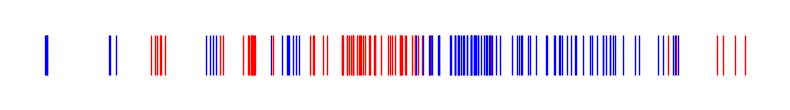

In [411]:

x1d = X_tsne1.ravel()
labels = df[LABEL_COL]        # 1 or 2, same as before

# map class → colour (same scheme as before)
colormap = {1: "red", 2: "blue"}
cols     = [colormap[l] for l in labels]

# ───────────────────────── 1-D coloured line ─────────────────────────────
fig, ax = plt.subplots(figsize=(8, 1.2))

# one tick per point: marker "|" is a short vertical line
ax.scatter(
    x1d, np.zeros_like(x1d),      # y = 0 ⇒ *no* second dimension
    c=cols, marker="|", s=800,    # s controls length & thickness
    linewidths=1
)

ax.set_axis_off()                # kill all axes, ticks, spines
plt.tight_layout()
plt.show()


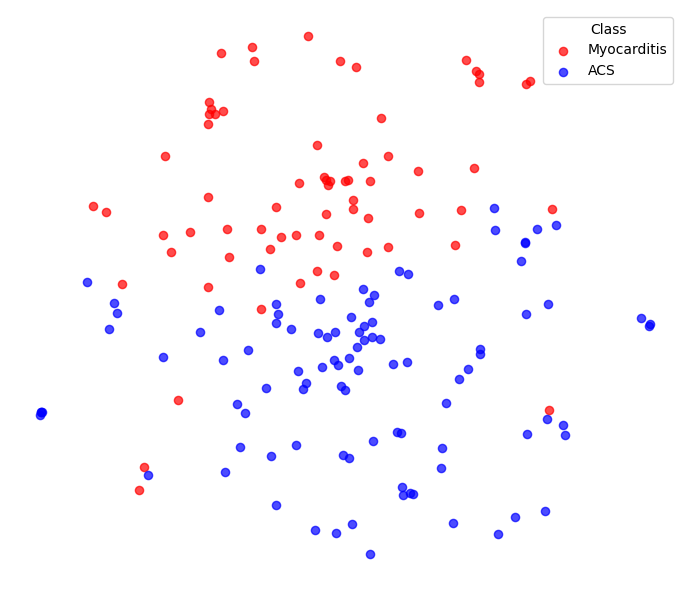

In [412]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto',
            init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

labels = df[LABEL_COL]  # 1 or 2

plt.figure(figsize=(7,6))

# Plot each class separately with label for legend
for cls, color in zip([1, 2], ['red', 'blue']):
    idx = labels == cls
    if cls == 1:
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                c=color, label=f'Myocarditis', s=35, alpha=0.7)
    if cls == 2:
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                c=color, label=f'ACS', s=35, alpha=0.7)


plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
#plt.title(f't-SNE projection of the uncertainty matrix X')

plt.gca().set_axis_off()

plt.legend(title="Class", loc='best')
plt.tight_layout()

plt.savefig("tSNE.pdf", dpi=300)
plt.show()

In [413]:
X_tsne.shape

(166, 2)

In [414]:

plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 12


In [415]:
# Padding around extreme points so contours don't touch the frame
pad = 2.0

xmin, xmax = X_tsne[:, 0].min() - pad, X_tsne[:, 0].max() + pad
ymin, ymax = X_tsne[:, 1].min() - pad, X_tsne[:, 1].max() + pad

# 250×250 grid (adjust for speed ↔ smoothness)
resolution = 1000
xs = np.linspace(xmin, xmax, resolution)
ys = np.linspace(ymin, ymax, resolution)
xx, yy = np.meshgrid(xs, ys)
grid = np.vstack([xx.ravel(), yy.ravel()])


In [416]:
class1 = X_tsne[labels == 1]
class2 = X_tsne[labels == 2]

kde1 = gaussian_kde(class1.T, bw_method="scott")
kde2 = gaussian_kde(class2.T, bw_method="scott")

z1 = kde1(grid).reshape(xx.shape)
z2 = kde2(grid).reshape(xx.shape)


In [417]:
z1[2,5]

np.float64(4.5584033200555545e-08)

In [418]:
q = 0.6                                                     # 60 % iso-density
level1 = np.quantile(z1, q)
level2 = np.quantile(z2, q)

overlap = (z1 >= level1) & (z2 >= level2)

In [419]:
# --- 6.  Build alpha masks & colour-shift for the overlap -----------------
def normalise(z, clip=0.98):
    """Scale density field to 0–1, clipping the top `clip` quantile."""
    zmax = np.quantile(z, clip)
    return np.clip(z / zmax, 0, 1)

# -------------------------------------------------------------------------
# 1) Alpha masks for the *pure* class regions (same idea as before)
# -------------------------------------------------------------------------
alpha1 = normalise(z1)**0.5
alpha2 = normalise(z2)**0.5
alpha1[z1 < level1] = 0.0
alpha2[z2 < level2] = 0.0

# -------------------------------------------------------------------------
# 2) Identify the overlap and give it its own alpha map
# -------------------------------------------------------------------------
overlap_mask      = (alpha1 > 0) & (alpha2 > 0)
alpha_overlap     = np.maximum(alpha1, alpha2)
alpha_overlap[~overlap_mask] = 0.0

# Remove the red/blue alphas *inside* the overlap so they don't sit on top
alpha1[overlap_mask] = 0.0
alpha2[overlap_mask] = 0.0

# -------------------------------------------------------------------------
# 3) Per-pixel colour for the overlap
#    • Start from mid-grey  (0.5, 0.5, 0.5)
#    • Shift toward red or blue according to local dominance
# -------------------------------------------------------------------------
eps   = 1e-12                    # avoid division by zero
total = z1 + z2 + eps
t     = (z1 - z2) / total        # -1 ⟶ pure blue side, +1 ⟶ pure red side

shift_strength = 0.3    # 0 → always grey, base_gray → full red/blue at edge

# Base: all grey
R = np.full_like(t, 0.5)
G = np.full_like(t, 0.5)
B = np.full_like(t, 0.5)

# Shift toward red where t > 0
pos          = t > 0
R[pos] += shift_strength * t[pos]
G[pos] -= shift_strength * t[pos]
B[pos] -= shift_strength * t[pos]

# Shift toward blue where t < 0
neg          = t < 0
B[neg] += shift_strength * (-t[neg])
R[neg] -= shift_strength * (-t[neg])
G[neg] -= shift_strength * (-t[neg])

shape = (*alpha1.shape, 4)        # (Ny, Nx, 4)

red_img  = np.zeros(shape)
red_img[..., 0] = 1.0             # R channel
red_img[..., 3] = alpha1          # alpha   (class-1 density)

blue_img = np.zeros(shape)
blue_img[..., 2] = 1.0            # B channel
blue_img[..., 3] = alpha2         # alpha   (class-2 density)

# Build the RGBA image for the overlap
shape      = (*alpha_overlap.shape, 4)
over_img   = np.zeros(shape)
over_img[..., 0] = R
over_img[..., 1] = G
over_img[..., 2] = B
over_img[..., 3] = alpha_overlap        # density-weighted fade-out


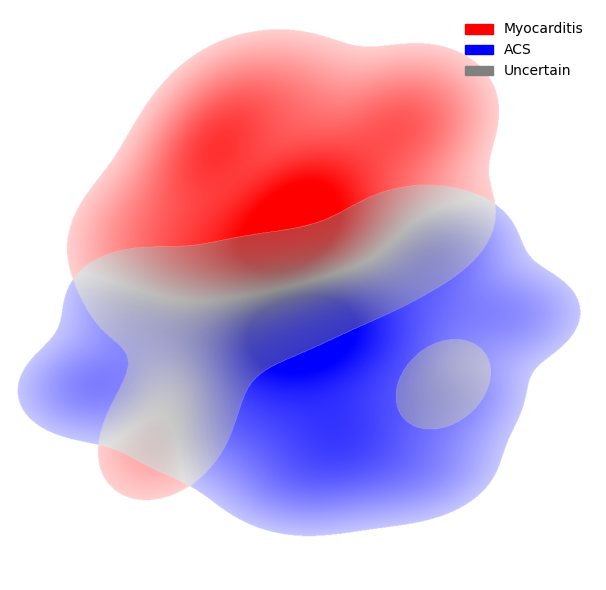

In [420]:
# --- Plot, final clean look ----------------------------------------------
fig, ax = plt.subplots()

# 🔧 1)  ⟵  **REMOVE** the scatter-plot calls
# for cls, color, label in [(1, "red", "Myocarditis"),
#                           (2, "blue", "ACS")]:
#     idx = labels == cls
#     ax.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
#                c=color, s=35, alpha=0.7, label=label)

# Filled RGBA layers (unchanged)
for img in [over_img, red_img, blue_img]:
    ax.imshow(img, extent=(xmin, xmax, ymin, ymax), origin="lower", interpolation="bilinear")

# 🔧 2)  ⟵  **COMMENT-OUT** the three outline-contour lines if you haven’t already
# ax.contour(...)
# ax.contour(...)
# ax.contour(...)

# 🔧 3)  ⟵  **Hide the entire axes frame** (ticks, spines, labels)
ax.set_axis_off()          # ‘off’ removes ticks, spines and axis labels

# 🔧 4)  ⟵  **Remove the overall title** (and legend, if not useful anymore)
# ax.set_title("t-SNE projection — filled regions only")   # ← delete / comment
# ax.legend_.remove()   # uncomment this line if a legend still exists

from matplotlib.patches import Patch   # add at the top of the cell if not imported

# ── proxy artists just for the legend ────────────────────────────
legend_handles = [
    Patch(facecolor="red",  edgecolor="red",  label="Myocarditis"),
    Patch(facecolor="blue", edgecolor="blue", label="ACS"),
    Patch(facecolor="gray", edgecolor="gray", label="Uncertain")
]

ax.legend(handles=legend_handles, loc="upper right", frameon=False)

plt.tight_layout()
plt.savefig("viz.pdf", dpi=300)
plt.show()


In [421]:
print(df_clean[LABEL_COL].value_counts())
print(df_clean[LABEL_COL].value_counts(normalize=True))

GRUP
2    98
1    68
Name: count, dtype: int64
GRUP
2    0.590361
1    0.409639
Name: proportion, dtype: float64


In [422]:
# IMPORTS

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [423]:
#train-test split

X_raw = df_clean.drop(columns=[LABEL_COL]).copy()
y = df_clean[LABEL_COL].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train_raw))
print("Test size :", len(X_test_raw))

Train size: 132
Test size : 34


In [424]:
#fit uncertainty transform to train

features = X_train_raw.columns.tolist()

entropy_train = {}
js_train = {}
stats_train = {}
disc_train_cache = {}

for feat in features:

    # --- discretise ONLY TRAIN
    disc_train = discretise(X_train_raw[feat])
    disc_train_cache[feat] = disc_train  # only train

    # --- class-conditional PMFs
    p1 = get_distribution(disc_train[y_train == 1])
    p2 = get_distribution(disc_train[y_train == 2])

    entropy_train[feat] = {
        1: shannon_entropy(p1),
        2: shannon_entropy(p2)
    }

    js_train[feat] = max(EPS, js_divergence(p1, p2))

    # --- μ, σ per class
    vals1 = X_train_raw.loc[y_train == 1, feat].dropna()
    vals2 = X_train_raw.loc[y_train == 2, feat].dropna()

    if len(vals1) == 0 or len(vals2) == 0:
        print(f"⚠️ Feature '{feat}' skipped (empty class).")
        continue

    stats_train[feat] = {
        1: {"mu": vals1.mean(), "std": vals1.std(ddof=0) + EPS},
        2: {"mu": vals2.mean(), "std": vals2.std(ddof=0) + EPS}
    }

In [425]:
# helpers
def transform(df, stats_train, entropy_train, js_train):
    rows = []

    for _, row in df.iterrows():
        vec = []

        for feat in stats_train.keys():
            v = row[feat]

            z1 = (v - stats_train[feat][1]["mu"]) / stats_train[feat][1]["std"]
            z2 = (v - stats_train[feat][2]["mu"]) / stats_train[feat][2]["std"]

            if abs(z1) < abs(z2):
                z = z1
                cls = 1
            else:
                z = z2
                cls = 2

            h = entropy_train[feat][cls]
            js_f = js_train[feat]

            vec.append(z * (h / (js_f + EPS)))

        rows.append(vec)

    return np.array(rows)

def learning_curve_uncertainty_train_test(
    X_raw,
    y,
    model,
    train_sizes,
    n_splits=5,
    random_state=42
):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import recall_score
    import numpy as np
    import pandas as pd

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    rng = np.random.default_rng(random_state)

    train_means, train_stds = [], []
    val_means,   val_stds   = [], []

    for n_train in train_sizes:

        tr_scores, va_scores = [], []

        for train_idx, val_idx in skf.split(X_raw, y):

            # -----------------------------
            # Subsample TRAIN (random)
            # -----------------------------
            if n_train > len(train_idx):
                continue

            sub_idx = rng.choice(train_idx, size=n_train, replace=False)

            X_train_raw = X_raw.iloc[sub_idx]
            y_train     = y[sub_idx]

            X_val_raw = X_raw.iloc[val_idx]
            y_val     = y[val_idx]

            # -----------------------------
            # UNCERTAINTY (TRAIN ONLY)
            # -----------------------------
            entropy_train, js_train, stats_train = {}, {}, {}

            for feat in X_train_raw.columns:

                disc = discretise(X_train_raw[feat])
                p1 = get_distribution(disc[y_train == 1])
                p2 = get_distribution(disc[y_train == 2])

                if len(p1) == 0 or len(p2) == 0:
                    continue

                vals1 = X_train_raw[feat][y_train == 1]
                vals2 = X_train_raw[feat][y_train == 2]

                if len(vals1) < 2 or len(vals2) < 2:
                    continue

                entropy_train[feat] = {
                    1: shannon_entropy(p1),
                    2: shannon_entropy(p2)
                }

                js_train[feat] = max(EPS, js_divergence(p1, p2))

                stats_train[feat] = {
                    1: {"mu": vals1.mean(), "std": vals1.std(ddof=0) + EPS},
                    2: {"mu": vals2.mean(), "std": vals2.std(ddof=0) + EPS}
                }

            # -----------------------------
            # TRANSFORM
            # -----------------------------
            X_tr = pd.DataFrame(
                transform(X_train_raw, stats_train, entropy_train, js_train),
                index=X_train_raw.index
            )
            X_va = pd.DataFrame(
                transform(X_val_raw, stats_train, entropy_train, js_train),
                index=X_val_raw.index
            )

            # -----------------------------
            # Drop NaN samples
            # -----------------------------
            tr_mask = ~X_tr.isna().any(axis=1)
            va_mask = ~X_va.isna().any(axis=1)

            X_tr = X_tr[tr_mask]
            X_va = X_va[va_mask]

            y_tr = y_train[tr_mask.values]
            y_va = y_val[va_mask.values]

            if len(np.unique(y_tr)) < 2 or len(np.unique(y_va)) < 2:
                continue

            # -----------------------------
            # Scale
            # -----------------------------
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_va_s = scaler.transform(X_va)

            # -----------------------------
            # Fit / Predict
            # -----------------------------
            model.fit(X_tr_s, y_tr)

            tr_scores.append(
                recall_score(y_tr, model.predict(X_tr_s),
                             average="macro", zero_division=0)
            )
            va_scores.append(
                recall_score(y_va, model.predict(X_va_s),
                             average="macro", zero_division=0)
            )

        train_means.append(np.mean(tr_scores))
        train_stds.append(np.std(tr_scores))

        val_means.append(np.mean(va_scores))
        val_stds.append(np.std(va_scores))

    return (
        np.array(train_means), np.array(train_stds),
        np.array(val_means),   np.array(val_stds)
    )

In [426]:
#train & test
X_train = transform(X_train_raw, stats_train, entropy_train, js_train)
X_test  = transform(X_test_raw,  stats_train, entropy_train, js_train)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
y_prob = clf.predict_proba(X_test_s)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro")
rec_macro  = recall_score(y_test, y_pred, average="macro")
f1_macro   = f1_score(y_test, y_pred, average="macro")
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("\n=== CLASSIFICATION METRICS ===")
print("Accuracy       :", round(acc,4))
print("Precision      :", round(prec_macro,4))
print("Recall (macro) :", round(rec_macro,4))
print("F1-score       :", round(f1_macro,4))
print("ROC-AUC        :", round(auc,4))

print("\n=== CONFUSION MATRIX ===")
print(cm)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))


=== CLASSIFICATION METRICS ===
Accuracy       : 0.9412
Precision      : 0.9545
Recall (macro) : 0.9286
F1-score       : 0.9377
ROC-AUC        : 0.95

=== CONFUSION MATRIX ===
[[12  2]
 [ 0 20]]

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           1       1.00      0.86      0.92        14
           2       0.91      1.00      0.95        20

    accuracy                           0.94        34
   macro avg       0.95      0.93      0.94        34
weighted avg       0.95      0.94      0.94        34



In [427]:
#classifier table
models = {
    "k-NN (k = 15)": KNeighborsClassifier(n_neighbors=15),
    "Random Forest": RandomForestClassifier(
      n_estimators=300,
      max_depth=4,
      min_samples_leaf=5,
      min_samples_split=10,
      max_features=0.5,
      class_weight="balanced",
      random_state=42
    ),
    "SVC (RBF)":     SVC(kernel="rbf", probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=3000)
}

results = {}

for name, model in models.items():
    model.fit(X_train_s, y_train)
    y_pred_m = model.predict(X_test_s)
    acc_m = accuracy_score(y_test, y_pred_m)
    results[name] = round(acc_m, 4)

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Accuracy"])
results_df.index.name = "Classifier"

print("\n=== BASELINE CLASSIFIER ACCURACY ON UNCERTAINTY MATRIX ===")
print(results_df.to_string())


=== BASELINE CLASSIFIER ACCURACY ON UNCERTAINTY MATRIX ===
                     Accuracy
Classifier                   
k-NN (k = 15)          0.8235
Random Forest          0.9706
SVC (RBF)              0.8235
Logistic Regression    0.9412


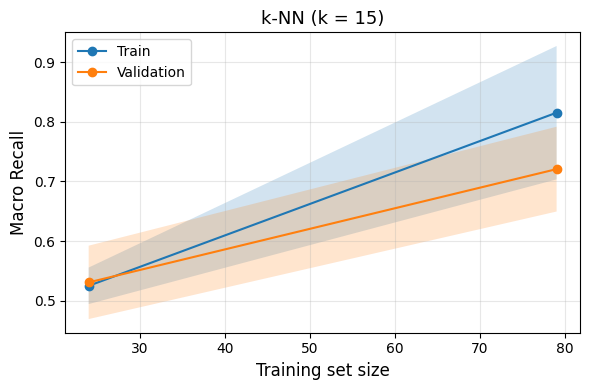

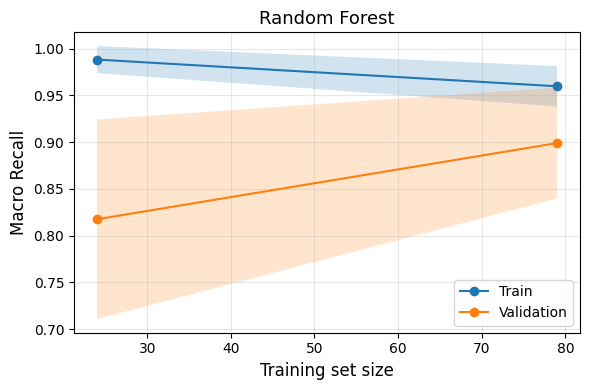

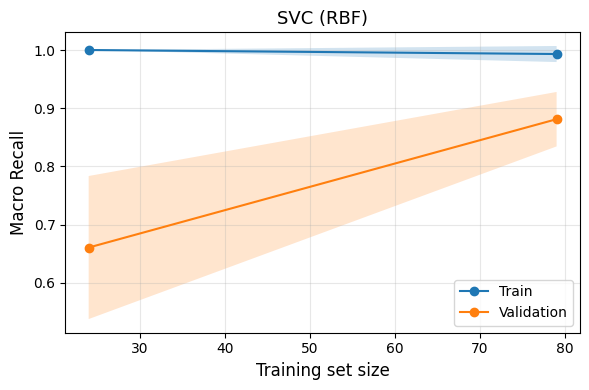

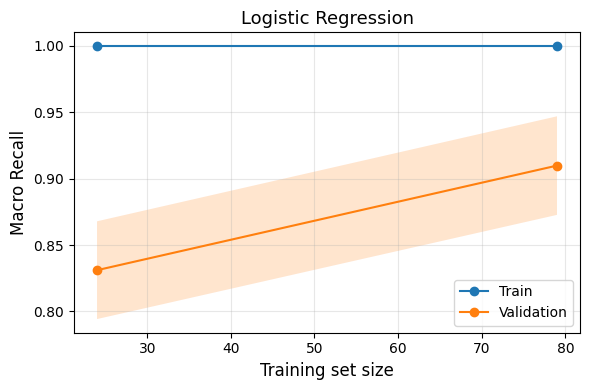

In [428]:
X_raw = df_clean.drop(columns=[LABEL_COL])
y_all = df_clean[LABEL_COL].values

train_sizes = [24, 79, 134, 189, 244]

for name, model in models.items():

    tr_m, tr_s, va_m, va_s = learning_curve_uncertainty_train_test(
        X_raw, y_all, model, train_sizes
    )

    plt.figure(figsize=(6,4))

    plt.plot(train_sizes, tr_m, 'o-', label="Train")
    plt.fill_between(train_sizes, tr_m-tr_s, tr_m+tr_s, alpha=0.2)

    plt.plot(train_sizes, va_m, 'o-', label="Validation")
    plt.fill_between(train_sizes, va_m-va_s, va_m+va_s, alpha=0.2)

    plt.xlabel("Training set size")
    plt.ylabel("Macro Recall")
    plt.title(name)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [429]:
def stratified_cv_all_models(X_raw, y, models, n_splits=5):

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=42
    )

    all_results = []

    for model_name, model in models.items():

        accs, precs, recs, f1s = [], [], [], []

        for train_idx, val_idx in skf.split(X_raw, y):

            X_train_raw = X_raw.iloc[train_idx]
            X_val_raw   = X_raw.iloc[val_idx]
            y_train     = y[train_idx]
            y_val       = y[val_idx]

            # transform (TRAIN)
            entropy_train, js_train, stats_train = {}, {}, {}

            for feat in X_train_raw.columns:

                disc = discretise(X_train_raw[feat])

                p1 = get_distribution(disc[y_train == 1])
                p2 = get_distribution(disc[y_train == 2])

                entropy_train[feat] = {
                    1: shannon_entropy(p1),
                    2: shannon_entropy(p2)
                }

                js_train[feat] = max(EPS, js_divergence(p1, p2))

                vals1 = X_train_raw[feat][y_train == 1]
                vals2 = X_train_raw[feat][y_train == 2]

                stats_train[feat] = {
                    1: {"mu": vals1.mean(), "std": vals1.std(ddof=0) + EPS},
                    2: {"mu": vals2.mean(), "std": vals2.std(ddof=0) + EPS}
                }

            # transform
            X_tr = transform(X_train_raw, stats_train, entropy_train, js_train)
            X_va = transform(X_val_raw,   stats_train, entropy_train, js_train)

            # scaling
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_va_s = scaler.transform(X_va)

            # model fit & predict
            model.fit(X_tr_s, y_train)
            y_pred = model.predict(X_va_s)

            # metrics
            accs.append(accuracy_score(y_val, y_pred))
            precs.append(precision_score(y_val, y_pred, average="macro", zero_division=0))
            recs.append(recall_score(y_val, y_pred, average="macro", zero_division=0))
            f1s.append(f1_score(y_val, y_pred, average="macro", zero_division=0))

        all_results.append({
            "Model": model_name,
            "Accuracy": f"{np.mean(accs):.3f} ± {np.std(accs):.3f}",
            "Precision_macro": f"{np.mean(precs):.3f} ± {np.std(precs):.3f}",
            "Recall_macro": f"{np.mean(recs):.3f} ± {np.std(recs):.3f}",
            "F1_macro": f"{np.mean(f1s):.3f} ± {np.std(f1s):.3f}"
        })

    return pd.DataFrame(all_results)


In [430]:
X_raw = df_clean.drop(columns=[LABEL_COL])
y_all = df_clean[LABEL_COL].values

cv_results = stratified_cv_all_models(X_raw, y_all, models, n_splits=5)

print("\n=== STRATIFIED CV RESULTS (TRAIN SET) ===")
print(cv_results.to_string(index=False))


=== STRATIFIED CV RESULTS (TRAIN SET) ===
              Model      Accuracy Precision_macro  Recall_macro      F1_macro
      k-NN (k = 15) 0.856 ± 0.069   0.887 ± 0.042 0.833 ± 0.083 0.838 ± 0.084
      Random Forest 0.952 ± 0.040   0.951 ± 0.041 0.951 ± 0.041 0.951 ± 0.041
          SVC (RBF) 0.904 ± 0.057   0.904 ± 0.057 0.900 ± 0.064 0.900 ± 0.060
Logistic Regression 0.952 ± 0.023   0.955 ± 0.026 0.949 ± 0.023 0.950 ± 0.024


In [431]:
print("\n" + "="*80)
print("TEST SET EVALUATION - FULL TRAIN")
print("="*80)

# X_train_s, X_test_s, y_train, y_test already exist

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=3000, random_state=42),
    "k-NN (k=15)": KNeighborsClassifier(n_neighbors=15),
    "SVC (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42)
}

results = []

for name, clf in classifiers.items():
    print(f"\n{'='*80}")
    print(f"{name}")
    print('='*80)

    # Train
    clf.fit(X_train_s, y_train)

    # Predict
    y_pred = clf.predict(X_test_s)
    y_prob = clf.predict_proba(X_test_s)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Myocarditis', 'ACS']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print(f"TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")

    # Store results
    results.append({
        'Classifier': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
    })

# Summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
summary_df = pd.DataFrame(results)
print(summary_df.to_string(index=False))


TEST SET EVALUATION - FULL TRAIN

Logistic Regression

Classification Report:
              precision    recall  f1-score   support

 Myocarditis       1.00      0.86      0.92        14
         ACS       0.91      1.00      0.95        20

    accuracy                           0.94        34
   macro avg       0.95      0.93      0.94        34
weighted avg       0.95      0.94      0.94        34

Confusion Matrix:
[[12  2]
 [ 0 20]]
TN=12, FP=2, FN=0, TP=20

k-NN (k=15)

Classification Report:
              precision    recall  f1-score   support

 Myocarditis       1.00      0.57      0.73        14
         ACS       0.77      1.00      0.87        20

    accuracy                           0.82        34
   macro avg       0.88      0.79      0.80        34
weighted avg       0.86      0.82      0.81        34

Confusion Matrix:
[[ 8  6]
 [ 0 20]]
TN=8, FP=6, FN=0, TP=20

SVC (RBF)

Classification Report:
              precision    recall  f1-score   support

 Myocarditis     